In [102]:
import numpy as np
import matplotlib.pyplot as plt
import time

### OvR Kernel Perceptron

In [103]:
class OvRKernelPerceptron:
    def __init__(self, class_labels, hyperparam=3):
        self.class_labels = class_labels    # list of class labels
        self.label_to_index = {label: i for i, label in enumerate(class_labels)}
        self.hyperparam = hyperparam        # kernel hyperparameter
        self.alphas = {}               # dict of alphas for each classifier
        self.train_kernel_matrix = None      # precomputed kernel matrix, for train data x train data
        self.train_data = None

    def _compute_kernel_matrix(self, data1, data2):
        return (data1[:, 1:257] @ data2[:, 1:257].T) ** self.hyperparam

    def _initialise_classifiers(self, data):
        for j in self.class_labels:
            self.alphas[j] = np.zeros(len(data))  # initially all alphas are zero
        # Precompute the kernel matrix for training data - improved efficiency
        self.train_kernel_matrix = self._compute_kernel_matrix(data, data)
        self.train_data = data

    def _binary_class_prediction(self, t, j, kernel_matrix):
        alphas = self.alphas[j]
        prediction = np.dot(alphas, kernel_matrix[t])
        return prediction
    
    def predict(self, i, kernel_matrix):   # OvR prediction
        max_pred = -1e18
        predicted_class = None

        for j in self.class_labels:
            y_pred = self._binary_class_prediction(i, j, kernel_matrix)
            if y_pred > max_pred:
                max_pred = y_pred
                predicted_class = j

        return predicted_class
    
    def train_classifiers(self, data, n_epochs):
        self._initialise_classifiers(data)
        m = len(data)

        for _ in range(n_epochs):   # effectively the same as extending training data, alphas are cumulative
            for t in range(m):      # online learning
                true_class = int(data[t][0])
                
                # Train each binary classifier
                for j in self.class_labels:
                    y = 1.0 if (true_class == j) else -1.0      # OvR label for binary classifier
                    y_pred = self._binary_class_prediction(t, j, self.train_kernel_matrix)

                    # Update if mistake
                    if y * y_pred <= 0:     # equivalent to y != 'y_pred'
                        self.alphas[j][t] += y  # update alpha for current example (cumulative over epochs)
    
    def evaluate_error(self, data, return_confusion_matrix=False, is_on_train=False,
                       update_hardest_to_predict=False, hardest_examples_dict=None):
        mistakes = 0

        if is_on_train:
            kernel_matrix = self.train_kernel_matrix
        else:
            # compute kernel matrix for test data x train data
            kernel_matrix = self._compute_kernel_matrix(data, self.train_data)

        if return_confusion_matrix:
            k = len(self.class_labels)
            confusion_matrix = np.zeros((k, k))
            label_counts = {j:0 for j in self.class_labels}

        for i in range(len(data)):
            true_label = int(data[i][0])

            if return_confusion_matrix:
                label_counts[true_label] += 1

            # predict by getting confidence scores from all classifiers
            predicted_class = self.predict(i, kernel_matrix)

            if predicted_class != true_label:
                mistakes += 1
                if return_confusion_matrix:
                    row = self.label_to_index[true_label]
                    col = self.label_to_index[predicted_class]
                    confusion_matrix[row][col] += 1
                # global hardest examples tracking
                if update_hardest_to_predict:
                    sample_key = tuple(data[i]) # use entire sample as key
                    if sample_key not in hardest_examples_dict:
                        hardest_examples_dict[sample_key] = 0
                    hardest_examples_dict[sample_key] += 1

        error_rate = mistakes / len(data)
        
        if return_confusion_matrix:
            # normalize confusion matrix by true label counts
            for i, j in enumerate(self.class_labels):
                if label_counts[j] > 0:
                    confusion_matrix[i] /= label_counts[j]
            return error_rate, confusion_matrix
        
        return error_rate
    
    def run(self, train_data, test_data, n_epochs, verbose=True):
        # Training the perceptron - note we do not want online training error
        start_time = time.time()
        self.train_classifiers(train_data, n_epochs)
        training_time = time.time() - start_time
        if verbose:
            print(f"Training required {training_time:.2f}s")
        
        # Evaluate on training data (once trained)
        start_time = time.time()
        train_error = self.evaluate_error(train_data, is_on_train=True)
        train_time = time.time() - start_time
        if verbose:
            print(f"Evaluating on training data required {train_time:.2f}s, "
                f"with a train error of {train_error:.4f}")
        
        # Evaluation on test data
        start_time = time.time()
        test_error = self.evaluate_error(test_data)
        test_time = time.time() - start_time
        if verbose:
            print(f"Evaluating on testing data required {test_time:.2f}s, "
                f"with a test error of {test_error:.4f}")
        
        return train_error, test_error


### Testing

In [104]:
def plot_digit(char_data, ax=None):
    # First element is label, next 256 are pixel values
    label = int(char_data[0])
    pixels = char_data[1:257].reshape(16, 16)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    ax.imshow(pixels, cmap='gray')
    ax.set_title(f'The number {label}')
    ax.axis('off')
    return ax

#### Demo Run with 123 datasets

Training data shape: (329, 257)
Test data shape: (456, 257)


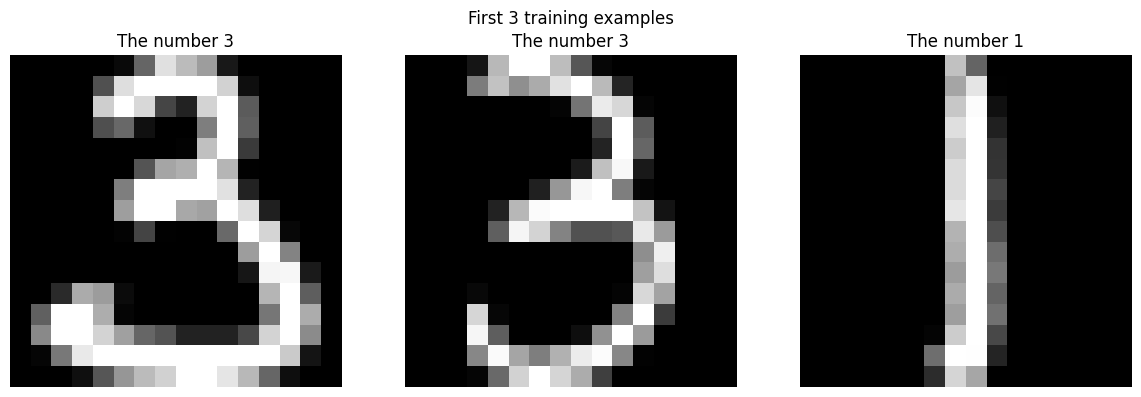


Running Kernel Perceptron Demo...
Training required 0.02s
Evaluating on training data required 0.00s, with a train error of 0.0000
Evaluating on testing data required 0.02s, with a test error of 0.0263


(0.0, 0.02631578947368421)

In [105]:
kp = OvRKernelPerceptron(class_labels=[1, 2, 3])
dtrain123 = np.loadtxt('dtrain123.dat')
dtest123 = np.loadtxt('dtest123.dat')
print(f"Training data shape: {dtrain123.shape}")
print(f"Test data shape: {dtest123.shape}")

# Plot first few digits
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for t in range(3):
    plot_digit(dtrain123[t], axes[t])
plt.suptitle("First 3 training examples")
plt.tight_layout()
plt.show()

# Run demo
print("\nRunning Kernel Perceptron Demo...")
np.random.seed(42)  # for reproducibility
kp.run(dtrain123, dtest123, 2)

#### Basic results with zipcombo dataset, for one run and polynomial degree=3

class labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Training data shape: (7438, 257)
Test data shape: (1860, 257)


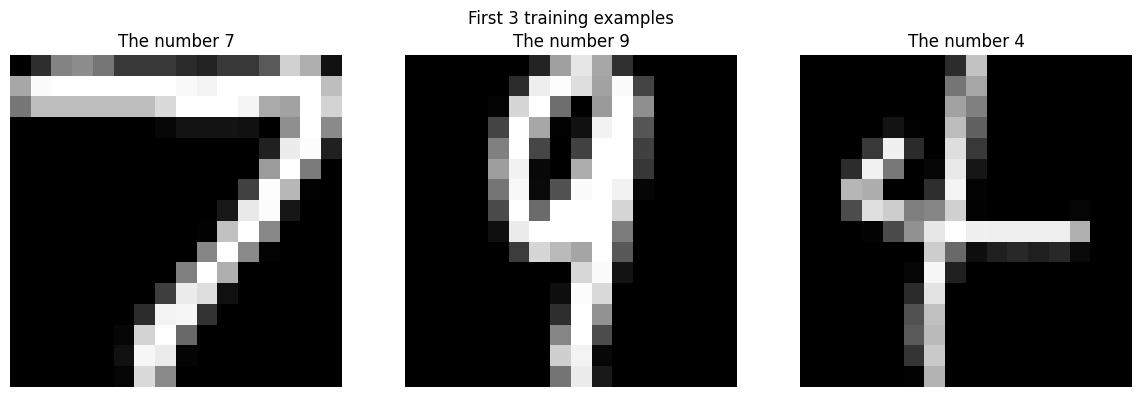


Running Kernel Perceptron Demo...
Training required 5.18s
Evaluating on training data required 0.45s, with a train error of 0.0028
Evaluating on testing data required 0.81s, with a test error of 0.0274


(0.00282333960742135, 0.027419354838709678)

In [106]:
kp = OvRKernelPerceptron(class_labels=[i for i in range(10)])

print("class labels:", kp.class_labels)
#zipcombo = zipcombo[:2000]
zipcombo = np.loadtxt('zipcombo.dat')
np.random.seed(42)  # for reproducibility

# random split into 80% train and 20% test
np.random.shuffle(zipcombo)
split_index = int(0.8 * len(zipcombo))
train_data = zipcombo[:split_index]
data = zipcombo[split_index:]

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {data.shape}")

# Plot first few digits
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for t in range(3):
    plot_digit(train_data[t], axes[t])
plt.suptitle("First 3 training examples")
plt.tight_layout()
plt.show()

# Run demo
print("\nRunning Kernel Perceptron Demo...")
kp.run(train_data, data, 3)

#### Train and test errors with zipcombo dataset, for 20 runs and polynomial degrees 1 to 7



=== Run 1 ===

-- Degree: 1 --
Training required 0.06s
Evaluating on training data required 0.01s, with a train error of 0.0775
Evaluating on testing data required 0.01s, with a test error of 0.2300

-- Degree: 2 --
Training required 0.05s
Evaluating on training data required 0.01s, with a train error of 0.0050
Evaluating on testing data required 0.01s, with a test error of 0.1100

-- Degree: 3 --
Training required 0.06s
Evaluating on training data required 0.01s, with a train error of 0.0000
Evaluating on testing data required 0.01s, with a test error of 0.1200

-- Degree: 4 --
Training required 0.06s
Evaluating on training data required 0.01s, with a train error of 0.0000
Evaluating on testing data required 0.01s, with a test error of 0.1100

-- Degree: 5 --
Training required 0.06s
Evaluating on training data required 0.01s, with a train error of 0.0025
Evaluating on testing data required 0.00s, with a test error of 0.0900

-- Degree: 6 --
Training required 0.06s
Evaluating on trai

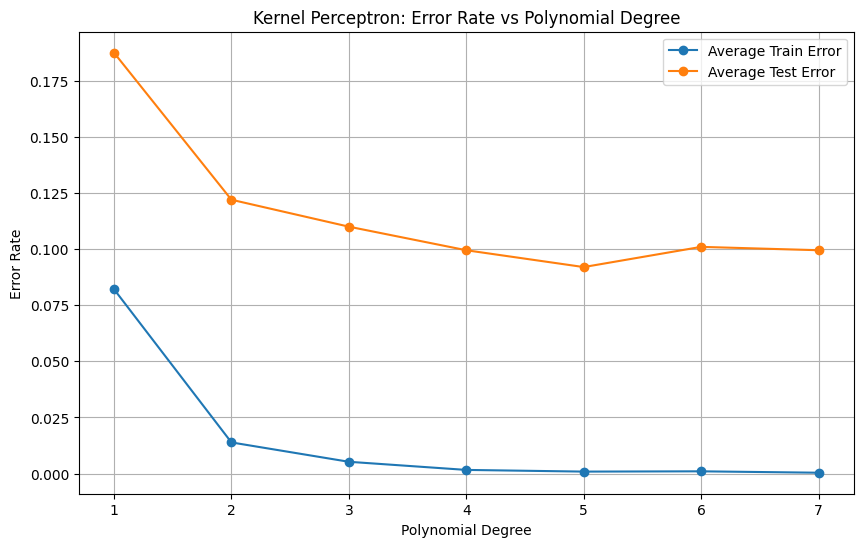

In [107]:
# TODO: run on thinlinc if too slow

zipcombo = np.loadtxt('zipcombo.dat')
zipcombo = zipcombo[:500]   # for quicker testing
np.random.seed(42)  # for reproducibility

degrees = [i for i in range(1, 8)]
n_runs = 20
train_errors = {d: [] for d in degrees}
test_errors = {d: [] for d in degrees}

for run in range(n_runs):

    print(f"\n\n=== Run {run + 1} ===")

    # random split into 80% train and 20% test
    np.random.shuffle(zipcombo)
    split_index = int(0.8 * len(zipcombo))
    train_data = zipcombo[:split_index]
    test_data = zipcombo[split_index:]

    for degree in degrees:

        print(f"\n-- Degree: {degree} --")

        # run the kernel perceptron
        kp = OvRKernelPerceptron(class_labels=[i for i in range(10)], hyperparam=degree)
        train_error, test_error = kp.run(train_data, test_data, 3)

        train_errors[degree].append(train_error)
        test_errors[degree].append(test_error)


# print average errors with std deviation, for table
print("\n\n=== Summary of Results ===")
for degree in degrees:
    avg_train_error = np.mean(train_errors[degree])
    std_train_error = np.std(train_errors[degree])
    avg_test_error = np.mean(test_errors[degree])
    std_test_error = np.std(test_errors[degree])
    print(f"\nDegree {degree}:")
    print(f"Average Train Error: {avg_train_error:.4f} ± {std_train_error:.4f}")
    print(f"Average Test Error: {avg_test_error:.4f} ± {std_test_error:.4f}")


# extra - plot average errors wrt degree
avg_train_errors = [np.mean(train_errors[degree]) for degree in degrees]
avg_test_errors = [np.mean(test_errors[degree]) for degree in degrees]
plt.figure(figsize=(10, 6))
plt.plot(degrees, avg_train_errors, marker='o', label='Average Train Error')
plt.plot(degrees, avg_test_errors, marker='o', label='Average Test Error')
plt.xticks(degrees)
plt.xlabel('Polynomial Degree')
plt.ylabel('Error Rate')
plt.title('Kernel Perceptron: Error Rate vs Polynomial Degree')
plt.legend()
plt.grid()
plt.show()


#### Cross validation to select best degree d, and record train and test errors, along with confusion matrix for test data and top 5 hardest to predict examples



=== Run 1 ===

--- Degree: 1 ---
-- Average Validation Error: 0.2000 --

--- Degree: 2 ---
-- Average Validation Error: 0.1275 --

--- Degree: 3 ---
-- Average Validation Error: 0.1200 --

--- Degree: 4 ---
-- Average Validation Error: 0.0975 --

--- Degree: 5 ---
-- Average Validation Error: 0.1225 --

--- Degree: 6 ---
-- Average Validation Error: 0.0975 --

--- Degree: 7 ---
-- Average Validation Error: 0.1200 --

---- Optimal degree d* for run 1 is: 4 ----


=== Run 2 ===

--- Degree: 1 ---
-- Average Validation Error: 0.1500 --

--- Degree: 2 ---
-- Average Validation Error: 0.0975 --

--- Degree: 3 ---
-- Average Validation Error: 0.0875 --

--- Degree: 4 ---
-- Average Validation Error: 0.0975 --

--- Degree: 5 ---
-- Average Validation Error: 0.0975 --

--- Degree: 6 ---
-- Average Validation Error: 0.1000 --

--- Degree: 7 ---
-- Average Validation Error: 0.0925 --

---- Optimal degree d* for run 2 is: 3 ----


=== Run 3 ===

--- Degree: 1 ---
-- Average Validation Error: 0.

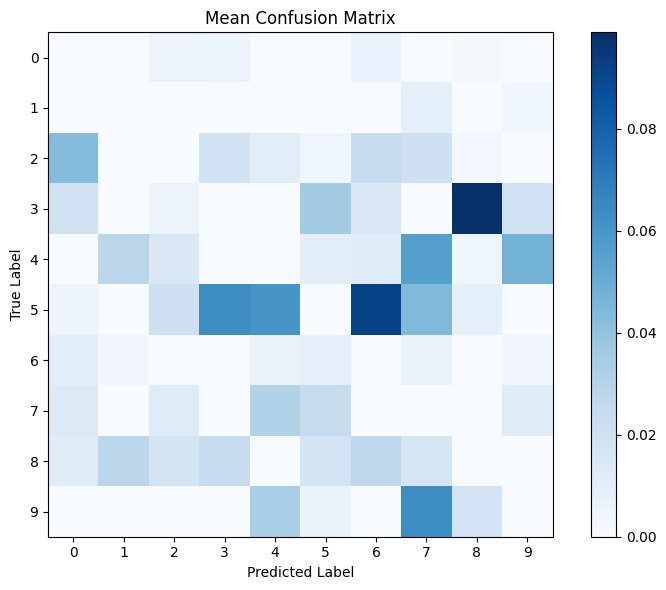

Count: 124
Count: 122
Count: 121
Count: 120
Count: 120


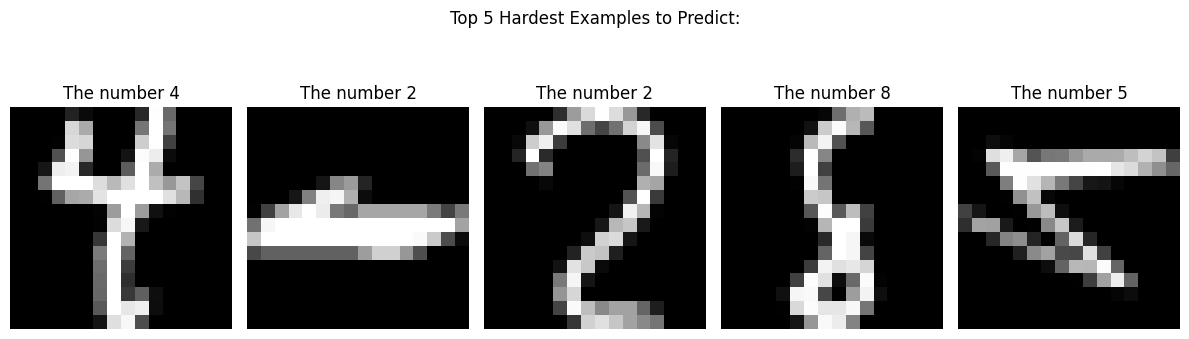

In [108]:
# TODO: run on thinlinc if too slow

zipcombo = np.loadtxt('zipcombo.dat')
zipcombo = zipcombo[:500]   # for quicker testing
np.random.seed(42)  # for reproducibility

degrees = [i for i in range(1, 8)]
n_runs = 20
d_stars = []
train_errors = []
test_errors = []
confusion_matrices = []
hardest_examples_overall = {}

for run in range(n_runs):

    print(f"\n\n=== Run {run + 1} ===")

    # random split into 80% train and 20% test
    np.random.shuffle(zipcombo)
    split_index = int(0.8 * len(zipcombo))
    train_data = zipcombo[:split_index]
    test_data = zipcombo[split_index:]

    # 5-fold cross-validation
    fold_size = len(train_data) // 5
    d_star = None
    min_val_error = float('inf')

    for degree in degrees:

        print(f"\n--- Degree: {degree} ---")

        fold_val_errors = []

        for fold in range(5):
            val_start = fold * fold_size
            val_end = (fold + 1) * fold_size if fold < 4 else len(train_data)

            val_data = train_data[val_start:val_end]
            train_fold_data = np.vstack((train_data[:val_start], train_data[val_end:]))

            # run the kernel perceptron
            kp = OvRKernelPerceptron(class_labels=[i for i in range(10)], hyperparam=degree)
            kp.train_classifiers(train_fold_data, 3)    # train on folded data
            val_error = kp.evaluate_error(val_data,     # evaluate on validation data
                                          update_hardest_to_predict=True, 
                                          hardest_examples_dict=hardest_examples_overall)

            fold_val_errors.append(val_error)

        avg_fold_val_error = np.mean(fold_val_errors)

        print(f"-- Average Validation Error: {avg_fold_val_error:.4f} --")

        # pick optimal degree, d*, based on lowest average validation error
        if avg_fold_val_error < min_val_error:
            min_val_error = avg_fold_val_error
            d_star = degree
    
    print(f"\n---- Optimal degree d* for run {run + 1} is: {d_star} ----")

    # retrain on full training data with d*
    kp = OvRKernelPerceptron(class_labels=[i for i in range(10)], hyperparam=d_star)
    kp.train_classifiers(train_data, 3)     # note: same epochs as in cv
    train_error = kp.evaluate_error(train_data, update_hardest_to_predict=True,
                                    hardest_examples_dict=hardest_examples_overall)
    test_error, return_confusion_matrix = kp.evaluate_error(test_data, return_confusion_matrix=True,
                                                            update_hardest_to_predict=True,
                                                            hardest_examples_dict=hardest_examples_overall)

    d_stars.append(d_star)
    train_errors.append(train_error)
    test_errors.append(test_error)
    confusion_matrices.append(return_confusion_matrix)


# print d* and average errors with std deviation for each run - for table
print("\n\n=== Summary of Results ===")
for run in range(n_runs):
    d_star = d_stars[run]
    train_error = train_errors[run]
    test_error = test_errors[run]
    return_confusion_matrix = confusion_matrices[run]
    print(f"Run {run + 1}: d* = {d_star}, Train Error = {train_error:.4f}, Test Error = {test_error:.4f}")
    print("Confusion Matrix:")
    print(return_confusion_matrix)


# print mean ± std of d*, train error, test error across all runs
mean_d_star = np.mean(d_stars)
std_d_star = np.std(d_stars)
mean_train_err = np.mean(train_errors)
std_train_err = np.std(train_errors)
mean_test_err = np.mean(test_errors)
std_test_err = np.std(test_errors)
mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
std_confusion_matrix = np.std(confusion_matrices, axis=0)
print(f"\nOverall d*: {mean_d_star:.2f} ± {std_d_star:.2f}")
print(f"Overall Train Error: {mean_train_err:.4f} ± {std_train_err:.4f}")
print(f"Overall Test Error: {mean_test_err:.4f} ± {std_test_err:.4f}")
print(f"\nMean Confusion Matrix:")
print(mean_confusion_matrix)
print(f"Std Confusion Matrix:")
print(std_confusion_matrix)

# plot of mean confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(mean_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Mean Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(kp.class_labels))
plt.xticks(tick_marks, kp.class_labels)
plt.yticks(tick_marks, kp.class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# extract top 5 hardest examples to predict (most frequently misclassified)
hardest_examples = sorted(hardest_examples_overall.items(), key=lambda x: x[1], reverse=True)[:5]
axis = 0
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for example, count in hardest_examples:
    print(f"Count: {count}")
    # plot the hardest example and its label
    plot_digit(np.array(example), axes[axis])
    axis += 1
plt.suptitle("Top 5 Hardest Examples to Predict:")
plt.tight_layout()
plt.show()
    